2023-12-04 16:41:44.322711: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


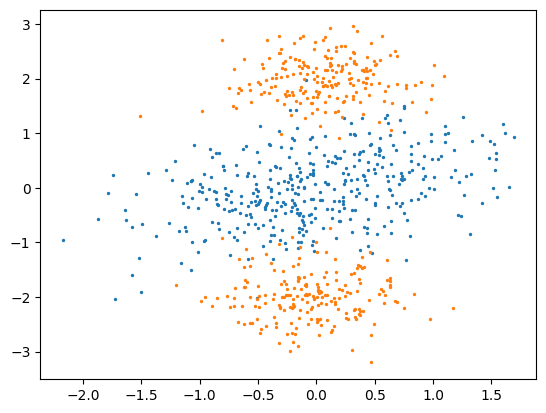

i: 0, loss: 1.6461256857811357
i: 1, loss: 1.9362595610281403
i: 2, loss: 0.9568056988880189
i: 3, loss: 1.3050905639455246
i: 4, loss: 0.9923627866176474
i: 5, loss: 0.612923713995985
i: 6, loss: 0.701676334367285
i: 7, loss: 0.6848680226529114
i: 8, loss: 0.4506582408674984
i: 9, loss: 0.24493333982504628
i: 10, loss: 0.37757544524663017
i: 11, loss: 0.41802943577716245
i: 12, loss: 0.28797625911780095
i: 13, loss: 0.19653809649405127
i: 14, loss: 0.302221476975481
i: 15, loss: 0.3004643203312187
i: 16, loss: 0.20248432375351158
i: 17, loss: 0.13547064569805495
i: 18, loss: 0.19992331244700057
i: 19, loss: 0.1909959158047456
i: 20, loss: 0.13963445124047227
i: 21, loss: 0.09722359233845161
i: 22, loss: 0.10542698933160315
i: 23, loss: 0.11596719652262151
i: 24, loss: 0.09226691028070466
i: 25, loss: 0.05781669927494069
i: 26, loss: 0.06359711290916857
i: 27, loss: 0.08396479199409257
i: 28, loss: 0.0915519687855659
i: 29, loss: 0.05858614156863793
i: 30, loss: 0.05098401299094723
i: 

In [1]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from fbs.dsb import ipf_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)

# Config
nsamples = 400
niters = 500
key = jax.random.PRNGKey(666)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()

dt = 0.01
nsteps = 100
T = nsteps * dt
ts = jnp.linspace(0, T, nsteps + 1)


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure Brownian motion
sigma = 1.


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=32, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=16, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param_fwd, _, nn_fwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=10, key=subkey)
key, subkey = jax.random.split(key)
init_param_bwd, _, nn_bwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=10, key=subkey)

schedule = optax.exponential_decay(1e-2, niters, 0.95)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, init_f, _, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, nn_fwd, _f_param, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_f_param, nn_fwd, nn_bwd, _b_param, _xTs, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss

opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

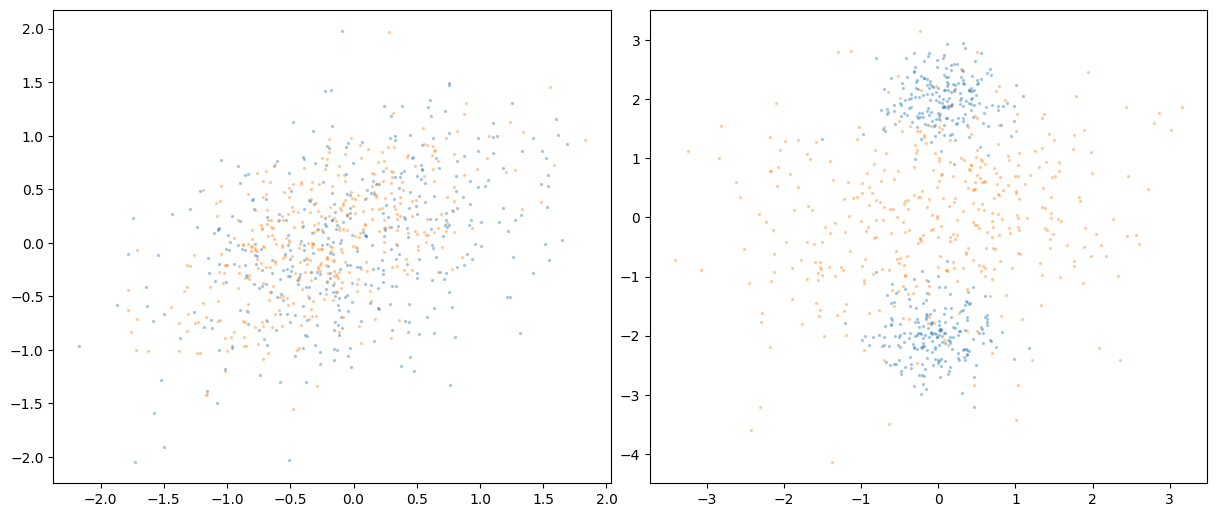

In [2]:
# Test if the reverse is learnt correctly
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [3]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 3.750551957852445
i: 1, loss: 3.158366581581711
i: 2, loss: 2.387771108731892
i: 3, loss: 1.7698702058974891
i: 4, loss: 1.2176412914746586
i: 5, loss: 0.9259568124015183
i: 6, loss: 0.6712954737461367
i: 7, loss: 0.49888211689041656
i: 8, loss: 0.4144793257765028
i: 9, loss: 0.3793511388541564
i: 10, loss: 0.4065733184247248
i: 11, loss: 0.46004356983332284
i: 12, loss: 0.4369210639352028
i: 13, loss: 0.3982659241716702
i: 14, loss: 0.3226792748530398
i: 15, loss: 0.23834333717893788
i: 16, loss: 0.18843195499504448
i: 17, loss: 0.1817267116975771
i: 18, loss: 0.19451681869123996
i: 19, loss: 0.19234658411831443
i: 20, loss: 0.20466072344118189
i: 21, loss: 0.19039993506179034
i: 22, loss: 0.1893932947930444
i: 23, loss: 0.17141973445447872
i: 24, loss: 0.15402788442063897
i: 25, loss: 0.12143958671446445
i: 26, loss: 0.08740731846571333
i: 27, loss: 0.0752128798199092
i: 28, loss: 0.07838146299551561
i: 29, loss: 0.07707940505810035
i: 30, loss: 0.09259300231525772
i: 31,

Exception ignored in: <function _xla_gc_callback at 0x7f024c186950>
Traceback (most recent call last):
  File "/home/zgbkdlm/Research/fbs/venv/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


i: 417, loss: 0.019013404436187605


KeyboardInterrupt: 

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()